In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from joblib import dump

In [33]:
grades_dataset_path = "/Users/gowthami/Documents/pythonProjects/DigitalMentorUS/data/Admission_Dataset.csv"
grades_dataset = pd.read_csv(grades_dataset_path)
grades_dataset.head()

,Program,Department,High School GPA,SAT Score,ACT Score,Advanced Coursework (0-10),STEM Extracurriculars (0-10),Leadership Experience (0-10),Letters of Recommendation (0-10),Personal Statement Quality (0-10),Diversity/Inclusion Contribution (0-10),Transfer Student GPA,Admission Accepted
0,Information Systems,Information Systems,3.87,1073,31,6,1,0,7,7,7,2.57,Yes
1,Bioinformatics and Computational Biology,Biological Sciences (in collaboration with COEIT),3.80,1410,23,3,9,5,8,7,6,3.31,No
2,Chemical Engineering,Biological Sciences (in collaboration with COEIT),2.71,1264,33,0,2,6,0,1,8,3.08,Yes
3,Electrical Engineering,Computer Science and Electrical Engineering,2.59,1316,24,7,1,8,0,5,3,3.16,Yes
4,Chemical Engineering,Information Systems,3.98,1569,31,3,6,6,0,10,7,2.59,No


In [792]:
#Exploratory Data Analysis of the Digital Mentor Admission Dataset

In [35]:
print(grades_dataset['Program'].value_counts())
print("\n", grades_dataset['Department'].value_counts())
print("\n", grades_dataset['Admission Accepted'].value_counts())

Program
Computer Science                            640
Bioinformatics and Computational Biology    615
Electrical Engineering                      603
Mechanical Engineering                      600
Computer Engineering                        599
Cybersecurity Informatics                   599
Information Systems                         598
Chemical Engineering                        588
Business TechNology Administration          579
Environmental Engineering                   579
Name: count, dtype: int64

 Department
Information Systems                                  1857
Computer Science and Electrical Engineering          1739
Chemical, Biochemical & Environmental Engineering    1191
Biological Sciences (in collaboration with COEIT)     625
Mechanical Engineering                                588
Name: count, dtype: int64

 Admission Accepted
Yes    4950
No     1050
Name: count, dtype: int64


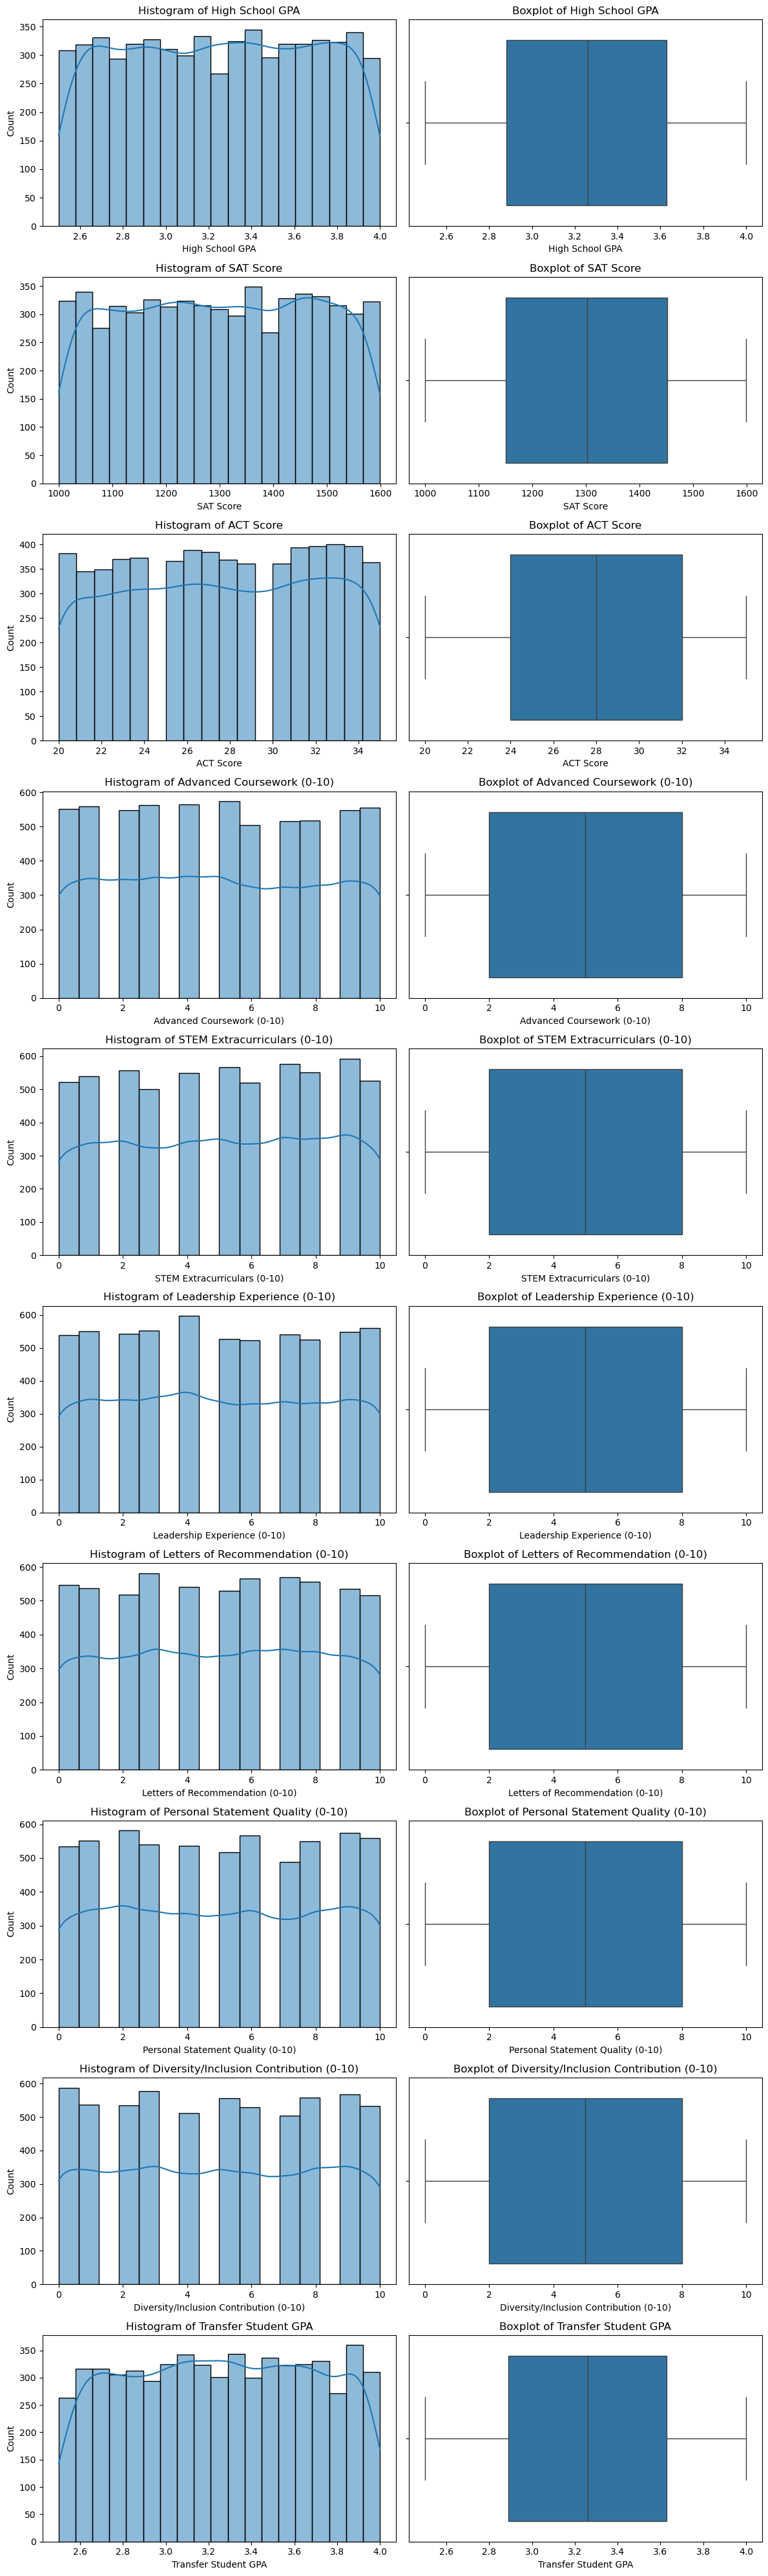

In [37]:
# Select numerical columns
numerical_cols = grades_dataset.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms and boxplots
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    sns.histplot(grades_dataset[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=grades_dataset[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [39]:
# Calculate skewness of each numerical feature
skewness = grades_dataset[numerical_cols].apply(lambda x: skew(x))
print("Skewness of numerical features:")
print(skewness)

Skewness of numerical features:
High School GPA                           -0.012794
SAT Score                                 -0.011842
ACT Score                                 -0.035697
Advanced Coursework (0-10)                 0.034217
STEM Extracurriculars (0-10)              -0.030497
Leadership Experience (0-10)               0.018819
Letters of Recommendation (0-10)          -0.009206
Personal Statement Quality (0-10)          0.010254
Diversity/Inclusion Contribution (0-10)    0.007302
Transfer Student GPA                      -0.013258
dtype: float64


In [41]:
# Function to find outliers using IQR
def find_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Apply to each feature and print outliers
for col in numerical_cols:
    outliers = find_outliers(grades_dataset, col)
    print(f"Outliers in {col}:", outliers.index.tolist())

Outliers in High School GPA: []
Outliers in SAT Score: []
Outliers in ACT Score: []
Outliers in Advanced Coursework (0-10): []
Outliers in STEM Extracurriculars (0-10): []
Outliers in Leadership Experience (0-10): []
Outliers in Letters of Recommendation (0-10): []
Outliers in Personal Statement Quality (0-10): []
Outliers in Diversity/Inclusion Contribution (0-10): []
Outliers in Transfer Student GPA: []


In [43]:
# Correcting skewness example using log transformation (where suitable)

for col in numerical_cols:
    if skew(grades_dataset[col]) > 0 or skew(grades_dataset[col]) < 0:
        grades_dataset[col] = np.log1p(grades_dataset[col])

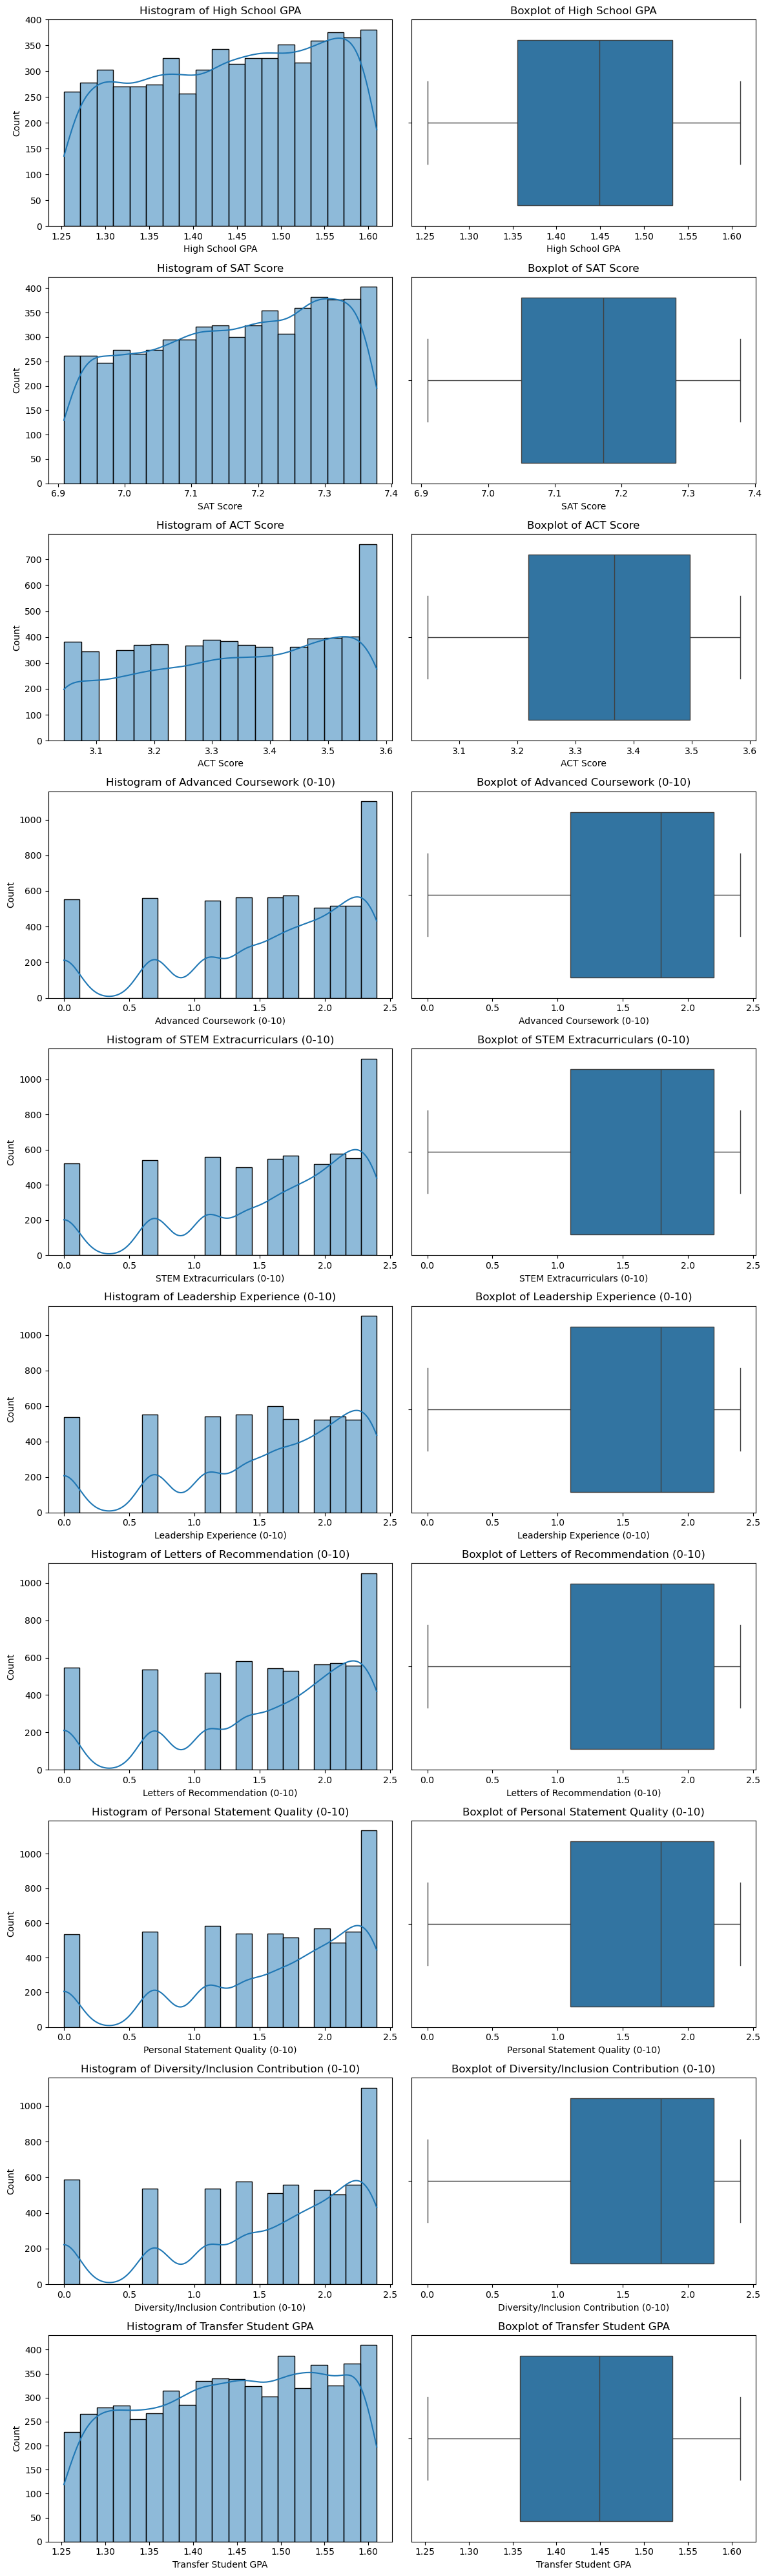

In [45]:
# Plot histograms and boxplots
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    sns.histplot(grades_dataset[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=grades_dataset[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [47]:
grades_dataset_encoded = pd.get_dummies(grades_dataset, columns=['Program', 'Department'])
grades_dataset_encoded.head(10)

,High School GPA,SAT Score,ACT Score,Advanced Coursework (0-10),STEM Extracurriculars (0-10),Leadership Experience (0-10),Letters of Recommendation (0-10),Personal Statement Quality (0-10),Diversity/Inclusion Contribution (0-10),Transfer Student GPA,...,Program_Cybersecurity Informatics,Program_Electrical Engineering,Program_Environmental Engineering,Program_Information Systems,Program_Mechanical Engineering,Department_Biological Sciences (in collaboration with COEIT),"Department_Chemical, Biochemical & Environmental Engineering",Department_Computer Science and Electrical Engineering,Department_Information Systems,Department_Mechanical Engineering
0,1.583094,6.979145,3.465736,1.945910,0.693147,0.000000,2.079442,2.079442,2.079442,1.272566,...,False,False,False,True,False,False,False,False,True,False
1,1.568616,7.252054,3.178054,1.386294,2.302585,1.791759,2.197225,2.079442,1.945910,1.460938,...,False,False,False,False,False,True,False,False,False,False
2,1.311032,7.142827,3.526361,0.000000,1.098612,1.945910,0.000000,0.693147,2.197225,1.406097,...,False,False,False,False,False,True,False,False,False,False
3,1.278152,7.183112,3.218876,2.079442,0.693147,2.197225,0.000000,1.791759,1.386294,1.425515,...,False,True,False,False,False,False,False,True,False,False
4,1.605430,7.358831,3.465736,1.386294,1.945910,1.945910,0.000000,2.397895,2.079442,1.278152,...,False,False,False,False,False,False,False,False,True,False
5,1.508512,7.117206,3.433987,0.000000,1.098612,2.397895,2.079442,2.397895,1.609438,1.534714,...,False,False,False,False,False,False,False,False,True,False
6,1.437463,7.080868,3.332205,1.609438,1.386294,1.791759,0.693147,2.302585,2.397895,1.585145,...,False,False,False,True,False,False,False,True,False,False
7,1.302913,7.301148,3.295837,2.079442,2.197225,2.397895,1.609438,1.945910,2.079442,1.553925,...,False,True,False,False,False,False,True,False,False,False
8,1.311032,7.215240,3.401197,2.302585,2.197225,1.945910,1.945910,2.079442,1.791759,1.324419,...,False,True,False,False,False,False,True,False,False,False
9,1.553925,7.305860,3.496508,2.197225,1.791759,1.609438,1.386294,0.693147,1.386294,1.366092,...,False,False,False,False,False,False,False,True,False,False


In [49]:
grades_dataset_encoded['Admission Accepted'] = grades_dataset['Admission Accepted'].apply(lambda x: 1 if x == 'Yes' else 0)

grades_dataset_encoded.head(10)

,High School GPA,SAT Score,ACT Score,Advanced Coursework (0-10),STEM Extracurriculars (0-10),Leadership Experience (0-10),Letters of Recommendation (0-10),Personal Statement Quality (0-10),Diversity/Inclusion Contribution (0-10),Transfer Student GPA,...,Program_Cybersecurity Informatics,Program_Electrical Engineering,Program_Environmental Engineering,Program_Information Systems,Program_Mechanical Engineering,Department_Biological Sciences (in collaboration with COEIT),"Department_Chemical, Biochemical & Environmental Engineering",Department_Computer Science and Electrical Engineering,Department_Information Systems,Department_Mechanical Engineering
0,1.583094,6.979145,3.465736,1.945910,0.693147,0.000000,2.079442,2.079442,2.079442,1.272566,...,False,False,False,True,False,False,False,False,True,False
1,1.568616,7.252054,3.178054,1.386294,2.302585,1.791759,2.197225,2.079442,1.945910,1.460938,...,False,False,False,False,False,True,False,False,False,False
2,1.311032,7.142827,3.526361,0.000000,1.098612,1.945910,0.000000,0.693147,2.197225,1.406097,...,False,False,False,False,False,True,False,False,False,False
3,1.278152,7.183112,3.218876,2.079442,0.693147,2.197225,0.000000,1.791759,1.386294,1.425515,...,False,True,False,False,False,False,False,True,False,False
4,1.605430,7.358831,3.465736,1.386294,1.945910,1.945910,0.000000,2.397895,2.079442,1.278152,...,False,False,False,False,False,False,False,False,True,False
5,1.508512,7.117206,3.433987,0.000000,1.098612,2.397895,2.079442,2.397895,1.609438,1.534714,...,False,False,False,False,False,False,False,False,True,False
6,1.437463,7.080868,3.332205,1.609438,1.386294,1.791759,0.693147,2.302585,2.397895,1.585145,...,False,False,False,True,False,False,False,True,False,False
7,1.302913,7.301148,3.295837,2.079442,2.197225,2.397895,1.609438,1.945910,2.079442,1.553925,...,False,True,False,False,False,False,True,False,False,False
8,1.311032,7.215240,3.401197,2.302585,2.197225,1.945910,1.945910,2.079442,1.791759,1.324419,...,False,True,False,False,False,False,True,False,False,False
9,1.553925,7.305860,3.496508,2.197225,1.791759,1.609438,1.386294,0.693147,1.386294,1.366092,...,False,False,False,False,False,False,False,True,False,False


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the features and the target
X = grades_dataset_encoded.drop('Admission Accepted', axis=1)
y = grades_dataset_encoded['Admission Accepted']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training set shape: (4800, 25)
Testing set shape: (1200, 25)
Training target shape: (4800,)
Testing target shape: (1200,)


In [55]:
# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the model to disk
model_filename = "/Users/gowthami/Documents/pythonProjects/DigitalMentorUS/models/scaler_pipeline.joblib"
dump(scaler, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /Users/gowthami/Documents/pythonProjects/DigitalMentorUS/models/scaler_pipeline.joblib


In [57]:
import joblib

# Load the saved scaler
model_filename = "/Users/gowthami/Documents/pythonProjects/DigitalMentorUS/models/scaler_pipeline.joblib"
scaler = joblib.load(model_filename)

# Print the attributes of the scaler
print("Feature names used during fit:", scaler.feature_names_in_)
print("Mean values used for scaling:", scaler.mean_)
print("Variance values used for scaling:", scaler.var_)

Feature names used during fit: ['High School GPA' 'SAT Score' 'ACT Score' 'Advanced Coursework (0-10)'
 'STEM Extracurriculars (0-10)' 'Leadership Experience (0-10)'
 'Letters of Recommendation (0-10)' 'Personal Statement Quality (0-10)'
 'Diversity/Inclusion Contribution (0-10)' 'Transfer Student GPA'
 'Program_Bioinformatics and Computational Biology'
 'Program_Business TechNology Administration'
 'Program_Chemical Engineering' 'Program_Computer Engineering'
 'Program_Computer Science' 'Program_Cybersecurity Informatics'
 'Program_Electrical Engineering' 'Program_Environmental Engineering'
 'Program_Information Systems' 'Program_Mechanical Engineering'
 'Department_Biological Sciences (in collaboration with COEIT)'
 'Department_Chemical, Biochemical & Environmental Engineering'
 'Department_Computer Science and Electrical Engineering'
 'Department_Information Systems' 'Department_Mechanical Engineering']
Mean values used for scaling: [1.44205803 7.16233751 3.33947072 1.5842347  1.601

In [59]:
X_test.columns

Index(['High School GPA', 'SAT Score', 'ACT Score',
       'Advanced Coursework (0-10)', 'STEM Extracurriculars (0-10)',
       'Leadership Experience (0-10)', 'Letters of Recommendation (0-10)',
       'Personal Statement Quality (0-10)',
       'Diversity/Inclusion Contribution (0-10)', 'Transfer Student GPA',
       'Program_Bioinformatics and Computational Biology',
       'Program_Business TechNology Administration',
       'Program_Chemical Engineering', 'Program_Computer Engineering',
       'Program_Computer Science', 'Program_Cybersecurity Informatics',
       'Program_Electrical Engineering', 'Program_Environmental Engineering',
       'Program_Information Systems', 'Program_Mechanical Engineering',
       'Department_Biological Sciences (in collaboration with COEIT)',
       'Department_Chemical, Biochemical & Environmental Engineering',
       'Department_Computer Science and Electrical Engineering',
       'Department_Information Systems', 'Department_Mechanical Engineerin

In [61]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [63]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Accuracy on test set:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy on test set: 0.8208333333333333
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.19      0.03      0.04       198
           1       0.84      0.98      0.90      1002

    accuracy                           0.82      1200
   macro avg       0.51      0.50      0.47      1200
weighted avg       0.73      0.82      0.76      1200



In [65]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy on test set:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy on test set: 0.5316666666666666
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.18      0.51      0.26       198
           1       0.85      0.54      0.66      1002

    accuracy                           0.53      1200
   macro avg       0.51      0.52      0.46      1200
weighted avg       0.74      0.53      0.59      1200



In [77]:
# Calculate the scale_pos_weight
# This is the ratio of number of negative class to the positive class
from xgboost import XGBClassifier
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize and train the XGBoost model with scale_pos_weight
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_smote, y_train_smote)  # Using SMOTE balanced data
y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost Accuracy on test set:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy on test set: 0.7383333333333333
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.21      0.21      0.21       198
           1       0.84      0.84      0.84      1002

    accuracy                           0.74      1200
   macro avg       0.53      0.53      0.53      1200
weighted avg       0.74      0.74      0.74      1200



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:35:43] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [82]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 6],
    'subsample': [0.8, 0.9, 1.0]
}

In [84]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', verbose=1)
grid_rf.fit(X_train_scaled, y_train)
print("Best parameters for RandomForest:", grid_rf.best_params_)
print("Best score for RandomForest:", grid_rf.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-

Best parameters for RandomForest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for RandomForest: 0.8227083333333333


In [86]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', verbose=1)
grid_lr.fit(X_train_smote, y_train_smote)
print("Best parameters for Logistic Regression:", grid_lr.best_params_)
print("Best score for Logistic Regression:", grid_lr.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.544836661562758


In [88]:
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss'), param_grid_xgb, cv=5, scoring='accuracy', verbose=1)
grid_xgb.fit(X_train_smote, y_train_smote)
print("Best parameters for XGBoost:", grid_xgb.best_params_)
print("Best score for XGBoost:", grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best score for XGBoost: 0.8899936668777709


In [90]:
# Assuming grid_lr, grid_rf, grid_xgb are the GridSearchCV objects for LogisticRegression, RandomForest, and XGBoost respectively
best_params_lr = grid_lr.best_params_
best_params_rf = grid_rf.best_params_
best_params_xgb = grid_xgb.best_params_

# Initialize the models with the best parameters
lr_best = LogisticRegression(**best_params_lr)
rf_best = RandomForestClassifier(**best_params_rf)
xgb_best = XGBClassifier(**best_params_xgb)

In [92]:
# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_best), ('rf', rf_best), ('xgb', xgb_best)],
    voting='soft'
)

In [94]:
# Train the ensemble model
voting_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = voting_clf.predict(X_test_scaled)

# Evaluate the ensemble model
print("Accuracy of Ensemble Model:", accuracy_score(y_test, y_pred))
print("Classification Report for Ensemble Model:\n", classification_report(y_test, y_pred))

Accuracy of Ensemble Model: 0.8191666666666667
Classification Report for Ensemble Model:
               precision    recall  f1-score   support

           0       0.12      0.02      0.03       198
           1       0.83      0.98      0.90      1002

    accuracy                           0.82      1200
   macro avg       0.48      0.50      0.46      1200
weighted avg       0.72      0.82      0.76      1200



In [96]:
from joblib import dump

# Save the model to disk
model_filename = "/Users/gowthami/Documents/pythonProjects/DigitalMentorUS/Models/admission_pipeline.joblib"
dump(voting_clf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /Users/gowthami/Documents/pythonProjects/DigitalMentorUS/Models/admission_pipeline.joblib
